

El Variatonal Quantum Eigensolver(VQE) [[1]](https://www.nature.com/articles/ncomms5213?origin=ppub)[[2]](https://pubs.acs.org/doi/10.1021/acs.chemrev.8b00803), es el algoritmo más conocido para química cuántica con aplicaciones realmente útiles en las computadoras cuánticas actualmente disponibles. Es una aplicación del [principio variacional de Ritz](https://en.wikipedia.org/wiki/Ritz_method) donde se usa la computadora cuántica para preparar la función de onda de ansatz (estado inicial elegido) de la molécula, se estima el valor de expectación del Hamiltoniano, y se usa un optimizador clásico para ajustar los parámetros del circuito cuántico hasta encontrar el estado fundamental de la molécula.

Para esto vamos a usar la libreria PennyLane, que es una libreria especializada en quantum machine learning. Quizas sea necesario reiniciar el entorno de ejecución luego de instalar los paquetes.

In [ ]:
%%capture
!pip install pennylane --upgrade
!pip install pennylane-qchem
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np

# Teoría: Como se calculan los orbitales atómicos 

### Hartree Fock

El método más simple es [Hartree-Fock (HF)](https://en.wikipedia.org/wiki/Hartree%E2%80%93Fock_method). Es un método de [campo medio](https://en.wikipedia.org/wiki/Mean-field_theory), donde se desprecian las correlaciones de Coulomb entre electrones. La función de onda de HF es simplemente un [determinante de Slater](https://en.wikipedia.org/wiki/Slater_determinant), que es la forma más simple de escribir un estado en un espacio antisimetrizado (las moléculas están hechas por [fermiones](https://en.wikipedia.org/wiki/Fermion), que requieren un espacio antisimetrizado). La optimización en esta solución se realiza sobre las posibles bases de una partícula (los orbitales). Una vez que hallamos los orbitales óptimos, el estado de HF es simplemente

$$ | \text{HF} \rangle = \prod_{p \in \text{occ}} \hat a^\dagger_p | \text{vac} \rangle $$

donde $\hat a^\dagger_p$ crea un electrón en el orbital de spin optimizado  $p^{\rm{th}}$, y  $| \text{vac} \rangle$ es el estado de vacío (todos los orbitales de spin desocupados). Debido a la simpleza en la función de onda, es muy eficiente calcular las energías, incluso para moléculas grandes. Sin embargo, la aproximación empeora cuando las correlaciones electrónicas son lo suficientemente fuertes. El estado de HF suele usarse de punto de partida para tratamientos más precisos.

### Coupled Clusters

El método de [Coupled cluster (CC)](https://en.wikipedia.org/wiki/Coupled_cluster) agrega correlaciones en su ansatz, agregandole al estado de HF ciertas interacciones básicas:

$$|\text{CC} \rangle = e^{\hat T} | \text{HF}\rangle, \quad \hat T = \hat T_1 + \hat T_2 + ...$$

donde $\hat T_1 = \sum_{ia} t^{a}_i \hat a^\dagger_a \hat a_i$ son operadores de "un cuerpo", $\hat T_2 = \sum_{ijab} t^{ab}_{ij} \hat a^\dagger_a \hat a^\dagger_b \hat a_i \hat a_j$ de "dos cuerpos", etc.
Cuando truncamos el desarrollo a uno (S por single) y dos (D por double), $\hat T = \hat T_1 + \hat T_2$, el ansatz correspondiente se conoce como  CCSD. Como el número de posibles excitaciones de 1 y 2 cuerpos para un sistema de $N$ electrones en $M$ orbitales es polinómico en $M$, podemos resolver eficientemente un sistema de ecuaciones obtenido a partir de optimizar las amplitudes de CCSD. Generalmente esto da energías precisas que pueden usarse en sistemas químicos relativamente pequeños. Sin embargo, debido a su implementación, puede violar el [principio variacional](https://en.wikipedia.org/wiki/Variational_principle) y dar energias menores a la del estado fundamental.

### Full Configuration Interaction

El método de [Full Configuration Interaction (FCI)](https://en.wikipedia.org/wiki/Full_configuration_interaction) devuelve la energía del estado fundamental exacta en una base dada. El estado de FCI se escribe como una combinación lineal de todos los osibles determinantes de Slater de $N$ partículas en una base dada

$$|\text{FCI} \rangle =  \left( \sum_{ia} C^{a}_i \hat a^\dagger_a \hat a_i + \sum_{ijab} C^{ab}_{ij} \hat a^\dagger_a \hat a^\dagger_b \hat a_i \hat a_j + ...  \right) | 0 \rangle $$

donde la suma incluye excitaciones de hasta $N$ electrones, y por tanto tenemos una cantidad exponencial de coeficientes para optimizar en $| \text{FCI} \rangle$. Debido a la complejidad exponencial, es posible aplicarlo solo en sistemas químico pequeños. Sin embargo es sumamente útil como benchmark para otros métodos.

# Construyendo el Hamiltoniano electrónico

Vamos a necesitar información sobre la molécula que queremos calcular. Para esto necesitamos la geometría, la carga y la multiplicidad de spin. 

Las geometrías están dadas por coordenadas 3-dimensionales. Hay varias bases de datos, como la [NIST Chemistry WebBook](https://webbook.nist.gov/chemistry/name-ser/), [ChemSpider](http://www.chemspider.com/) y [SMART-SNS](http://smart.sns.it/molecules/). 

Vamos a descargar la geometría.

In [ ]:
# Descargamos la geometria
!wget https://pennylane.ai/qml/_downloads/7191118aef248d2adc5fe59048afe782/h2.xyz
geometry = 'h2.xyz'

--2020-12-07 14:49:27--  https://pennylane.ai/qml/_downloads/7191118aef248d2adc5fe59048afe782/h2.xyz
Resolving pennylane.ai (pennylane.ai)... 13.226.49.107, 13.226.49.115, 13.226.49.70, ...
Connecting to pennylane.ai (pennylane.ai)|13.226.49.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 112 [chemical/x-xyz]
Saving to: ‘h2.xyz.3’

h2.xyz.3            100%[===================>]     112  --.-KB/s    in 0s      

2020-12-07 14:49:27 (17.3 MB/s) - ‘h2.xyz.3’ saved [112/112]




La carga determina el número de electrones quitados o agregados en realción a la molécula neutra.

La [multiplicidad](https://en.wikipedia.org/wiki/Multiplicity_(chemistry)) determina el número de electrones no pareados en el estado de [Hartree Fock](https://en.wikipedia.org/wiki/Hartree-Fock_method) (que es la aproximación estándar).

In [ ]:
# Consideramos molécula neutra
charge = 0
multiplicity = 1

Tenemos que especificar también la base elegida para aproximar los orbitales atómicos. Esto suele hacerse con una combinación de funciones Gaussianas. En este caso vamos a usar la base STO-3g, donde usamos un conjunto de 3 Gaussianas para representar un orbital atómico del tipo Slater:

In [ ]:
basis_set = 'sto-3g'

Podmos usar la función `molecular_hamiltonian()` de PennyLane, para lo cual tenemos que especificar el nombre de la molécula.




In [ ]:
name = 'h2'

Finalmente llamamos la función agregandole todos los parámetros faltantes, como el número de electrones y orbitales activos, el mapeo fermiónes a qubits elegido (que puede ser [Jordan Wigner](https://en.wikipedia.org/wiki/Jordan%E2%80%93Wigner_transformation), o [Bravyi Kitaev](https://arxiv.org/abs/quant-ph/0003137v2)). Los outputs son el Hamiltonian de qubits de la molécula y el número de qubits necesarios.

In [ ]:
h, qubits = qchem.molecular_hamiltonian(
    name,
    geometry,
    charge=charge,
    mult=multiplicity,
    basis=basis_set,
    active_electrons=2,
    active_orbitals=2,
    mapping='jordan_wigner'
)

print('Number of qubits = ', qubits)
print('Hamiltonian is ', h)

Number of qubits =  4
Hamiltonian is  (-0.04207897647782276) [I0]
+ (0.17771287465139946) [Z0]
+ (0.1777128746513994) [Z1]
+ (-0.24274280513140462) [Z2]
+ (-0.24274280513140462) [Z3]
+ (0.17059738328801052) [Z0 Z1]
+ (0.04475014401535161) [Y0 X1 X2 Y3]
+ (-0.04475014401535161) [Y0 Y1 X2 X3]
+ (-0.04475014401535161) [X0 X1 Y2 Y3]
+ (0.04475014401535161) [X0 Y1 Y2 X3]
+ (0.12293305056183798) [Z0 Z2]
+ (0.1676831945771896) [Z0 Z3]
+ (0.1676831945771896) [Z1 Z2]
+ (0.12293305056183798) [Z1 Z3]
+ (0.17627640804319591) [Z2 Z3]


# Implementando VQE

Definimos el device, que en este caso es un simulador de qubits.

In [ ]:
dev = qml.device('default.qubit', wires=qubits)

El objetivo de VQE es entrenar el circuito cuántico para preparar el estado fundamental del Hamiltoniano deseado. Para esto tenemos que construir un circuito particular, que sea lo suficientemente complejo como para preparar el estado fundamental, pero a la vez fácil de optimizar. En este ejemplo usamos un circuito variacional capaz de preparar estados normalizados del tipo $\alpha |1100\rangle + \beta |0011\rangle$, que alcanza para describir el estado fundamental de la molécula de hidrógeno. El circuito consiste de rotaciones de un electrón en cada cable, seguidos por 3 compuertas CNOT entrelazantes.

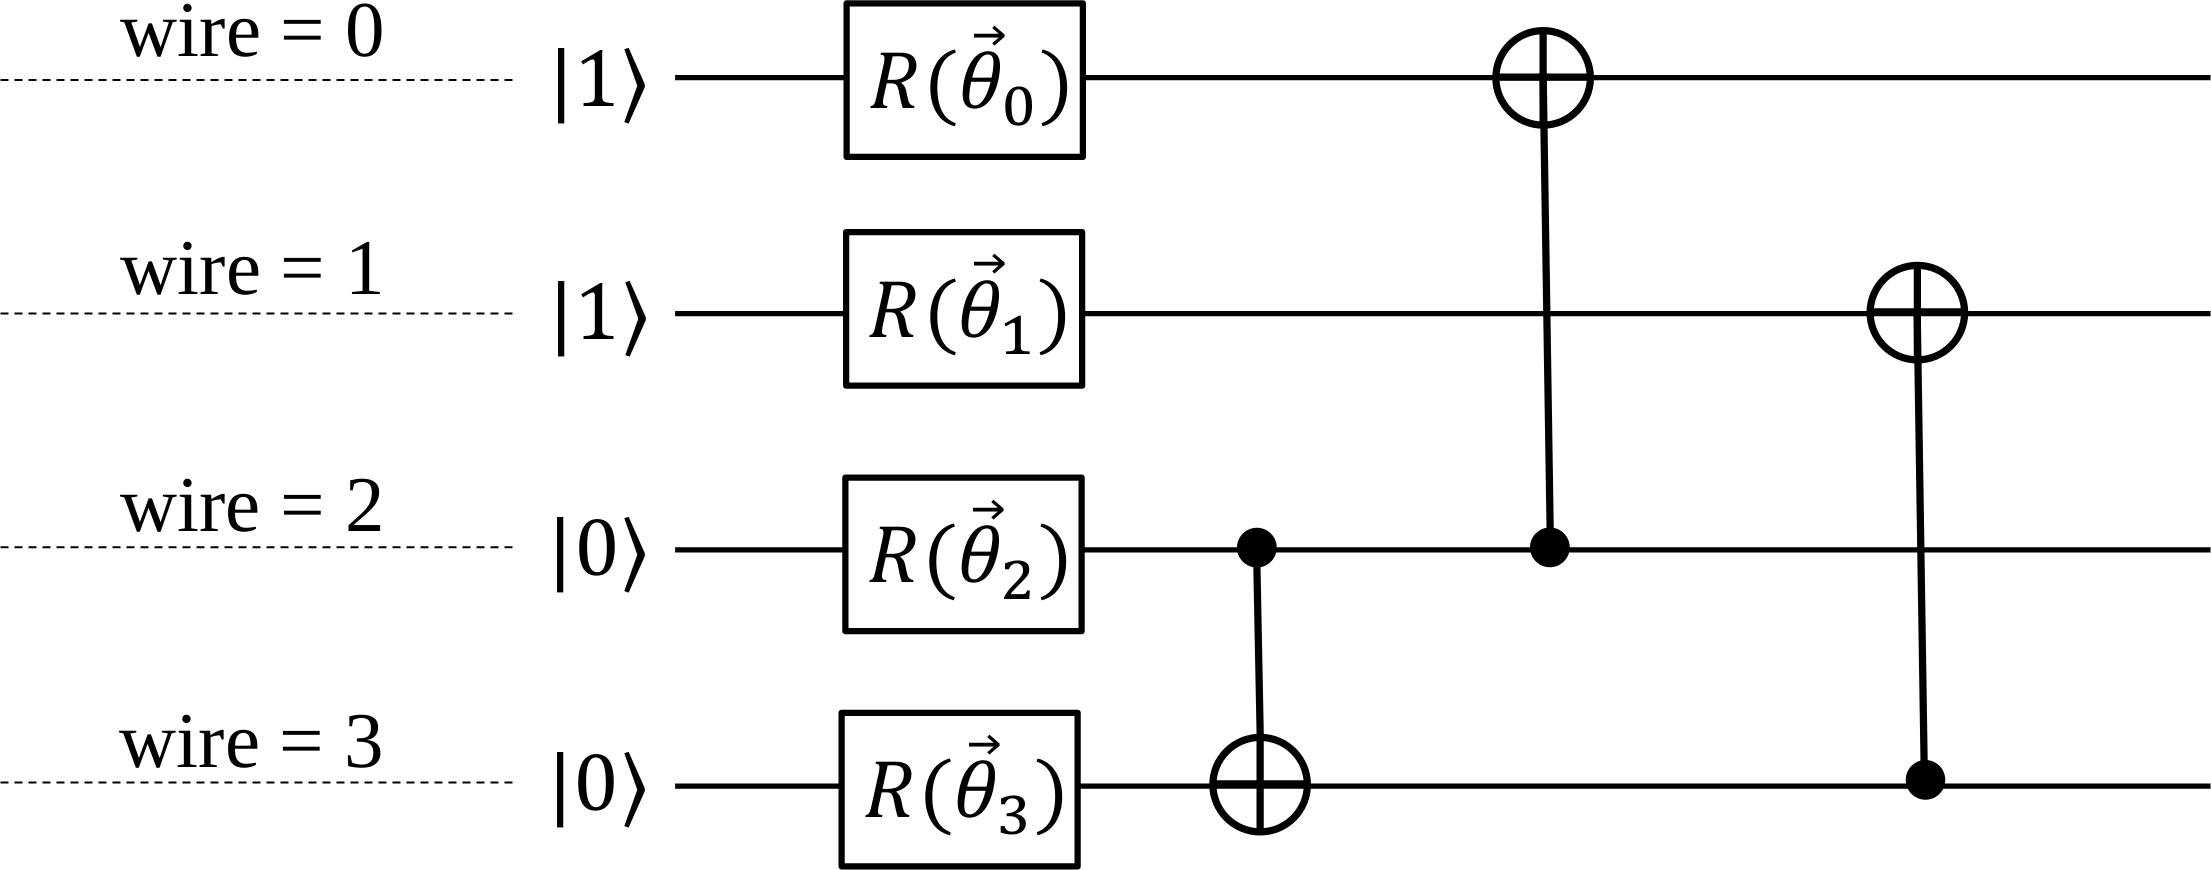

In [ ]:
def circuit(params, wires):
    qml.BasisState(np.array([1, 1, 0, 0]), wires=wires)
    for i in wires:
        qml.Rot(*params[i], wires=i)
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[2, 0])
    qml.CNOT(wires=[3, 1])

La función de costo para optimizar el circuito la creamos directamente con la clase `ExpvalCost`, que es específica para VQE. 

In [ ]:
cost_fn = qml.ExpvalCost(circuit, h, dev)

Fijamos el optimizador, inicializamos el circuito con parámetros random y fijamos una semilla para que sea replicable.

In [ ]:
opt = qml.GradientDescentOptimizer(stepsize=0.4)
np.random.seed(0)
params = np.random.normal(0, np.pi, (qubits, 3))

print(params)

[[ 5.54193389  1.25713095  3.07479606]
 [ 7.03997361  5.86710646 -3.07020901]
 [ 2.98479079 -0.47550269 -0.32427159]
 [ 1.28993324  0.45252622  4.56873497]]


Optimizamos 200 pasos, apuntando a tener una tolerancia (diferencia en la función costo en pasos subsiguientes) de $10^{-6}$

In [ ]:
max_iterations = 200
conv_tol = 1e-06

prev_energy = cost_fn(params)
for n in range(max_iterations):
    params = opt.step(cost_fn, params)
    energy = cost_fn(params)
    conv = np.abs(energy - prev_energy)

    if n % 20 == 0:
        print('Iteration = {:},  Energy = {:.8f} Ha'.format(n, energy))

    if conv <= conv_tol:
        break

    prev_energy = energy

print()
print('Final convergence parameter = {:.8f} Ha'.format(conv))
print('Final value of the ground-state energy = {:.8f} Ha'.format(energy))
print('Accuracy with respect to the FCI energy: {:.8f} Ha ({:.8f} kcal/mol)'.format(
    np.abs(energy - (-1.136189454088)), np.abs(energy - (-1.136189454088))*627.503
    )
)
print()
print('Final circuit parameters = \n', params)

Iteration = 0,  Energy = -0.88179557 Ha
Iteration = 20,  Energy = -1.13380513 Ha
Iteration = 40,  Energy = -1.13558756 Ha
Iteration = 60,  Energy = -1.13585794 Ha
Iteration = 80,  Energy = -1.13600617 Ha
Iteration = 100,  Energy = -1.13608848 Ha
Iteration = 120,  Energy = -1.13613394 Ha

Final convergence parameter = 0.00000099 Ha
Final value of the ground-state energy = -1.13615709 Ha
Accuracy with respect to the FCI energy: 0.00003237 Ha (0.02031093 kcal/mol)

Final circuit parameters = 
 [[ 5.54193389e+00  1.30219523e-08  3.07479606e+00]
 [ 7.03997361e+00  6.28318530e+00 -3.07020901e+00]
 [ 2.98479079e+00 -2.09540998e-01 -4.16893297e-02]
 [ 1.28993324e+00  1.30912762e-12  4.56873497e+00]]


Lo logramos! La energía del estado fundamental de la molécula de Hidrógeno quedó estimada con una precisión $< 1\; kcal/mol$ respecto al valor exacto de $-1.136189454088 \;Hartree$ que obtenemos con los cálculos mejorados de Full Configuration Interaction (FCI). De hecho el estado fundamental que obtuvimos es precisamente el estado fundamental de FCI para la molécula de $H_2$: 

$|H_2\rangle_{gs} = 0.99|1100\rangle - 0.10|0011\rangle$

# Referencias

[1] Alberto Peruzzo, Jarrod McClean et al., “A variational eigenvalue solver on a photonic quantum processor”. [Nature Communications 5, 4213 (2014)](https://www.nature.com/articles/ncomms5213?origin=ppub).


[2] Yudong Cao, Jonathan Romero, et al., “Quantum Chemistry in the Age of Quantum Computing”. [Chem. Rev. 2019, 119, 19, 10856-10915](https://pubs.acs.org/doi/10.1021/acs.chemrev.8b00803).

[Tutorial de VQE con PennyLane](https://pennylane.ai/qml/demos/tutorial_vqe.html)